IVADO Recommender Systems Workshop -- August 2019
=======

Tutorial: An Introduction to Practical Machine Learning
=============


This tutorial provides a short introduction to the practice of machine learning. We assume that the user already has an understanding of the basics. We review both methodological concepts like supervised and unsupervised learning, and also use software libraries such as scikit-learn, pandas, and numpy. In particular, we will load some data, fit different supervised models on the variations of the data, including a variation where some of the features have been clustered, and compare results. 

This is not meant to be exhaustive (several references are provided throughout, including at the end).  

### Authors: 
- Laurent Charlin <lcharlin@gmail.com>
- Didier Chetelat <>
- David Berger <>

### Context
As the introduction to a recommender-systems workshop we will model user-movie preferences from a popular publically available dataset (Movielens 1M). We will learn to predict user-movie ratings from user socio-demographics and movie-tags data.

Mathematically, we are interested in learning the (parameters of the) following function: 

$$ r_{um} = f_\theta(x_u, x_m)$$ 
where 
- $u$ indexes users 
- $m$ indexes items
- $r_{um}$ is u's rating for m (that user's preference). That's the dependant variable
- $f_\theta$ is some model parametrized by $\theta$. For example a linear regression with coefficients $\theta$
- $x_u$ are user u's covariates (e.g., age and occupation of this user)
- $x_m$ are movie m's covariates (e.g., tags associated with the movie)

The exact form of the function $f$ is left unspecified. In today's tutorial, we will try several ones from a simple linear regression model to a more complicated one-hidden layer neural network.


### Machine Learning terminology

It can be useful to think of machine learning as comprising of three elements:
1. Task (T)
2. Experience (E)
3. Performance measure (P).

(a good description of these concepts is provided in [Ch. 5 of the Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html))

The intuition is that the task (T) is the type of problem you are trying the solve (e.g., classification, regression, anomaly detection), the experience (E) is how your data comes about (e.g., does it come with labels or not, do you observe it all at once or as a stream), and the performance (P) is "how well your model does". Standard performance measure include accuracy and mean squared error.  

Note that the above terminology does not define the model used to learn (fit) the data nor does it define the fitting procedure (e.g., gradient descent).

Given the above: 
- Task: Today the task is to predict user-movie ratings. It can be modelled in different ways (more on this next tomorrow), but to begin we will model it as a regression problem. 
- Experience: The experience is a supervised learning one because we are predicting some dependant variable (rating) from a set of independant variables
- Performance measure: We will be using the mean-squared error.

### Setting up the data 

For supervised learning, it is customary, to construct two data matrix $X$ and $Y$. The former, $X$ contains the covariates (features). It is a matrix of size $n \times p$ with $n$ the number of examples and $p$ the dimensionality of each example (in other words the number of covariates associated with each example).  They are the input to the function. The latter, $Y$ is a (column) vector of length $n$ which contains the labels (here ratings). $Y_1$ corresponds to the rating of $X_1$ (row  contains the labels (here ratings).

$$X = \begin{bmatrix} 
x_{11} & x_{12} & \ldots & x_{1p} \\
\vdots & \ddots       &  \ddots      & \vdots \\ 
x_{n1} & x_{12} & \ldots & x_{np} \\
\end{bmatrix}
\;\;\;\;
Y = \begin{bmatrix} 
r_1 \\
r_2 \\
\vdots \\ 
r_n
\end{bmatrix}$$

Of course, in a real problem we will differentiate the `train` and `test` sets with $X_\text{train}$ and $X_\text{test}$. Same with labels data using $Y_\text{train}$ and $Y_\text{test}$.

Draft 
------
Draft
====

Content
	- Load data in 
	- Look at some descriptive stats
	- Run a model 
		- Average performance 
		- Individual output 
			- best/worse
		- Plot some output
			- e.g., training through time. 
		- More complicated model on same data. 
            - 1 hidden-layer neural network.
                a) output: regression
                b) output: half of the ratings. (use an autoencoder? would have to fix observed/unobserved...). 
		- save/load model. 
		- plug-in the result of one model into another. (cluster the tags, use the cluster memberships of each movie.)

## The start

We begin by importing some of the packages that we will need: 
- `reduce` function will come in handy to iteratively process data
- `os` as a standard packages for performing system operations (e.g., opening files)
- `re` package for regex
- `time` package we will use to measure the length of certain operations
- `numpy` for numerical calculations
- `pandas` for data wrangling 
- `matplotlib` for plotting
- `sklearn` (scikit-learn) for machine learning models and useful machine learning related routines

In [125]:
from functools import reduce
import os
import re 
import time

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import neural_network

# Section 1: Data Pre-Processing

In the following we are going to load data from several csv files and pre-process it. 

While this is not really machine learning, machine learning needs data and so knowing how to manipulate (and plot) data in python is quite useful. (In fact, in lots of use cases, data aquisition and cleaning will often take more time than running the machine learning models.)

#### Details

We will use the publically available [movielens dataset](https://grouplens.org/datasets/movielens/). The group behind movielens have released several useful datasets in the last 20 years. Here we will focus on the [ML-1M data](https://grouplens.org/datasets/movielens/1m/) (it contains 1M ratings) but we will also use movie tags from the [ML-20M dataset](https://grouplens.org/datasets/movielens/20m/) (20M ratings). 

Except for downloading the dataset (to reduce wasted time), I have not processed nor modified the data in any way.

In [2]:
DATA_DIR='dat/ml-1m/' # this is where most of our data lives
## Use ML-1M. Comes with user features. It comes with genres (not tags) but we can still cluster them.
## We could use the tags from ML-20M. We just have to match movies (movie IDs match between ML-1M and ML-20M)
## Keep the top N tags (say 100, or based on frequency), cluster these same tags.
# The model is: 
# y_ui = id_u b_u + id_i b_i + zip_u w2 + \sum_i tag_i wi + gender_u w + age_u w 
# notes: don't use movie genre. 
# 

We begin by loading the data that describes the movies in the ML-1M dataset. Each line in the file contains one entry in the following format `MovieID::Name::Genres`. 

After loading into a pandas `dataFrame` structure, we will have movie names (`mName`), IDs (`mid`), and movie genres (`mGenres`)

In [3]:
movies_pd = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'), 
                        sep='::', 
                        names=['mid', 'mName', 'mGenres'], engine='python')

In [4]:
print(f'The dataset contains {movies_pd.shape[0]} movies')

The dataset contains 3883 movies


In [5]:
display(movies_pd.head())

,mid,mName,mGenres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Using pandas we can also search for movies by `mid` or by their name:

In [6]:
mid = 10 
display(movies_pd[movies_pd.mid==mid])

name = 'Machine'
display(movies_pd[movies_pd.mName.str.contains(name, 
                                               regex=False, case=False)])

,mid,mName,mGenres
9,10,GoldenEye (1995),Action|Adventure|Thriller


,mid,mName,mGenres
1409,1433,"Machine, The (1994)",Comedy|Horror


Using a similar routine as above we load the ratings data which is in this format `UserID::MovieID::Rating::Timestamp`, and we will call index the user with `uid`, the movies with `mid`, the rating with `rating`, and the time of the rating with `timestamp`.

In [7]:
ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), 
                         sep='::',
                         names=['uid', 'mid', 'rating', 'timestamp'],
                         parse_dates=['timestamp'],
                         infer_datetime_format=True,
                         engine='python')

display(ratings_pd.head())

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
print(f"""The dataset contains {ratings_pd.shape[0]} ratings, 
      from {ratings_pd.uid.nunique()} users, 
      and {ratings_pd.mid.nunique()} items.""")

The dataset contains 1000209 ratings, 
      from 6040 users, 
      and 3706 items.


Load user socio-demographics information.

The file is in this format `UserID::Gender::Age::Occupation::Zip-code`, which we will load in a `dataFrame` with the following column names `uid,gender,age,occupation,zip`. 



In [9]:
users_pd = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'),
                       sep='::',
                       names=['uid', 'gender', 'age', 'occupation', 'zip'],
                       engine="python")

display(users_pd.head())

,uid,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [10]:
print(f'This table contains {users_pd.shape[0]} users')

This table contains 6040 users


Further we will truncate the 5-digit zip codes and only keep the leading two digits. The reason is that we will treat this variable as a categorical one and with only ~6K users, it is unlikely that we can learn precise enough coefficients for this variable. 

In [11]:
print(f'We originally have {users_pd.zip.nunique()} different zip codes')
users_pd['zip'] = users_pd['zip'].apply(lambda x: x[:2])
display(users_pd['zip'].head())
print(f'By only keep the first two digits of each zip code, we reduce the unique number of zip codes to {users_pd.zip.nunique()}.')

We originally have 3439 different zip codes


0    48
1    70
2    55
3    02
4    55
Name: zip, dtype: object

By only keep the first two digits of each zip code, we reduce the unique number of zip codes to 100.


The last information that we need to retrieve are the movie tags (we will actually use tags available from the ml-20M dataset). The tags are user generated, further each movie-tag pair comes with an affinity score (intuitively, if numerous users have used a tag on a particular movie than the tag-movie pair will have a high affinity).

We will load the csv data `movieId,tagId,relevance` into a `dataFrame` with the columns `mid,tid,relevance`. 

In [12]:
# load ml-20m tags
tags_scores = pd.read_csv('dat/ml-20m/genome-scores.csv.gz', 
                          skiprows=1, 
                          names=['mid', 'tid', 'relevance'])
display(tags_scores.head(10))

,mid,tid,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [13]:
print(f'The data contains {tags_scores.tid.nunique()} unique tags.')
print(f'Affinities (relevances) are contained in the {tags_scores.relevance.min()}--{tags_scores.relevance.max()} range.')
display(tags_scores.relevance.describe())

The data contains 1128 unique tags.
Affinities (relevances) are contained in the 0.00024999999999997247--1.0 range.


count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

From above we see that affinities (relevance) basically span the 0 to 1 range, and have an average of 0.12.

We also load the tag names. This will be useful for exploration purposes.

In [14]:
tags_names = pd.read_csv('dat/ml-20m/genome-tags.csv', skiprows=1, names=['tid', 'tName'])
display(tags_names.head(10))

,tid,tName
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


Since we loaded tag scores from a different dataset(ml-20M), we need only the tags that correspon to movies  in the original data (ml-1M). Luckily, since these are both from movielens, the movie ids (`mid`) are the same across these two datasets (i.e., not need for messy string match).

(Note: Pandas' functionalities allow you to do operations similar to what you would do with SQL with relational databases.)

In [15]:
tags_scores = tags_scores.loc[tags_scores['mid'].isin(ratings_pd['mid'].unique())]
print(tags_scores.mid.nunique())

3470


Note that we actually lost a few movies compared to the original count of 3706.

Next, instead of using the tag scores, we only keep high relevances. In other words, we assume that the presence of a tag is more meaningful than its absence. This also have the side benefit of reducing the number of available tags per movie. 

In [16]:
# Keep only high-relevance tags
print('unique tags:', tags_scores['tid'].nunique())
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]
print('unique tags w. high relevance:', tags_scores_high['tid'].nunique())

unique tags: 1128
unique tags w. high relevance: 968


#### Explore tags

Let's get some understanding of how these tags are used. To help, we first build a `dataFrame` that contains, the tag names, the movie name, and its relevance (recall that currrently these are three different tables, as the tag relevance contains tag and movie IDs but not their names). 

Pandas' `merge` function can be used to join two dataFrames that share a common key. (This is another operation inspired by SQL (inner join).)

In [17]:
tags_high_names_movies = pd.merge(tags_scores_high, tags_names, how='inner', on='tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movies_pd, how='inner', on='mid')
display(tags_high_names_movies.head())

,mid,tid,relevance,tName,mName,mGenres
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy


Similarly as above we can search for top movies according to a particular tag: 

In [18]:
tag = 'scary' # This is the (sub) tag we search for
display(tags_high_names_movies[
    tags_high_names_movies.tName.str.contains(tag, 
                                               regex=False, case=False)].sort_values(by=['relevance'],
                                                                                    ascending=False))

,mid,tid,relevance,tName,mName,mGenres
13151,2710,882,0.96700,scary,"Blair Witch Project, The (1999)",Horror
14005,1342,882,0.96625,scary,Candyman (1992),Horror
9205,1347,882,0.96550,scary,"Nightmare on Elm Street, A (1984)",Horror
14658,3892,882,0.96475,scary,Anatomy (Anatomie) (2000),Horror
3187,1997,882,0.96200,scary,"Exorcist, The (1973)",Horror
14021,2550,882,0.95625,scary,"Haunting, The (1963)",Horror|Thriller
11492,1350,882,0.94675,scary,"Omen, The (1976)",Horror
11546,2841,882,0.94650,scary,Stir of Echoes (1999),Thriller
9340,1974,882,0.94625,scary,Friday the 13th (1980),Horror
2976,1387,882,0.94250,scary,Jaws (1975),Action|Horror


This next step will allow us to further explore the tags data while providing an additional step of pre-processing that will be helpful for fitting this data. 

The problem is simple. We note that in the current dataset, every movie-tag id pair is a separate entry (row of the `dataFrame`). Thinking ahead, we will want to use all tags as covariates to predict a single rating. As such, we want to construct our data matrix to such that each line corresponds to a single example. 

First, we will re-encode `tid`s using a 1-of-K encoding or dummy variables. This is important to encode categorial variables (e.g., "cats" and "dogs") which may be represented numericaly but where there is not order. For example, here each tag has an numerical index (e.g., tag `scary` is id `882`) but tags cannot be compared using their numbers (e.g., tag `882` is not "bigger" than tag `880` or smaller than tag `900`). 1-of-K encoding deals with this by encoding each tag as a binary vector of length $K$ with a single non-zero value which corresponds to the tags. In the present case, $K=968$ tags, and tag `scary` would have a `1` at position `882`. 

Below we see that our data now has 971 columns: 968 for tag ids, 1 for `mid`, and 1 for `relevance`, and 1 for the pandas index.

In [19]:
#print(tags_scores_high.shape)
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns=['tid'])
tags_scores_high_dum = tags_scores_high_dum.reset_index()
#print(tags_scores_high_dum.shape)
display(tags_scores_high_dum.head())

,index,mid,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
0,62,1,0.93325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,1,0.98575,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,185,1,0.95650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,202,1,0.92625,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,203,1,0.96425,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With this data we can then explore the distribution of movies per tag (and tags per movie below). 

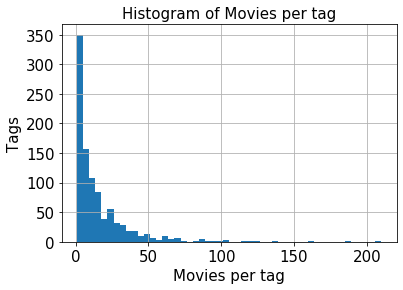

In [20]:
th = tags_scores_high.groupby("tid").count()
hists = th.hist(bins=50, column="mid", xlabelsize=15, ylabelsize=15)[0][0]
hists.set_ylabel("Tags", size=15)
hists.set_xlabel("Movies per tag", size=15)
hists.set_title("Histogram of Movies per tag", size=15);

In this histogram each bar corresponds to the number of tags (y-axis) associated with a particular number of movies. For example, there are 350 tags that were used to tag a small number of movies (<5). On the other hand, the most popular tag was used to tag 210 movies.

We note that the distribution if heavily skewed to the left which indicates that most tags are only used on a small number of movies.

In [21]:
tname = tags_names.at[tags_names.tid.eq(th.mid.idxmax()).idxmax(), 'tName']
print(f'The most popular tag "{tname}" has been used for {th.mid.max()} movies')

The most popular tag "comedy" has been used for 210 movies


Using the same recipe, we can do something similar for movies instead of tags

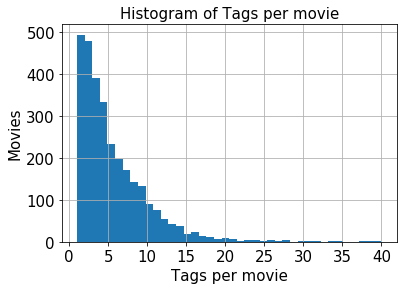

In [22]:
hists = tags_scores_high.groupby("mid").count().hist(bins=40, column="tid", xlabelsize=15, ylabelsize=15)
hists[0][0].set_ylabel("Movies", size=15)
hists[0][0].set_xlabel("Tags per movie", size=15)
hists[0][0].set_title("Histogram of Tags per movie", size=15);

In this histogram each bar corresponds to the number of movies (y-axis) associated with a particular number of tags. For example, there are a bit less than 500 movies that received exactly 1 tags. On the other hand, the most popular movie received almost 40 tags.

Q: What is the most popular movie in terms of tag (the one with almost 40 tags)? Can you list the top 5 movies in terms of number of tags? 

In [23]:
#mh = tags_scores_high.groupby("mid").count()
#tname = tags_names.at[tags_names.tid.eq(mh.tid.idxmax()).idxmax(), 'tName']
#print(f'The most popular tag "{tname}" has been used for {th.mid.max()} movies')

<a id='tag_clustering'></a>
# Section 1.1 Tag clustering

There are over 900 tags but most movies only contain a handful of tags (see above). In other words, tag representations for each movie (and equivalently for ratings) will be very sparse. For a given example, most covariates will be zero. 

This presents two challenges for machine learning methods: 
- We will need one parameter for each tag (so 900 parameters for tags)
- Each parameter will only be trained with a small number of data points which could make its estimation inprecise.

There are sever ways to deal with this. One is to use an $L1$ penalty on the weights (more details (here)[]). Another is to reduce the dimensionality of the tag representation. The intuition would be to capture dependancies between different tags and to use these dependancies to re-encode the tags of each movie using a lower-dimensional representation. 

Again, there are several ways of doing this. Here, we will use clustering. Clustering **groups** each data into a fixed number of groups. 

In this case, we first we cluster movies according to their tags. Then, we use the cluster of each movie as the covariate (instead of, or in addition to, the original representation). If there are 10 clusters, then we would reduce the dimensionality of the tag covariates from 900 to 10.

#### Clustering in scikit-learn

Scikit-learn proposes several clustering routines. Below we try three different ones. Before going into their details, let us first consider how to train a model using `scikit-learn`. 

Most models are trained in two steps:
1. instantiate the object: `model = sklearn.GreatModel(...)`)
2. Fit the object to data: `model.fit(X_train,Y_train)`

once the model is fit, it can be used to make predictions for missing data
3. Predict: `y_pred = model.predict(X_test)`

This API makes it very simple and efficient to experiment with different models in scikit-learn. As soon as the data is processed in a correct way, different methods can be easily compared.


Below we experiment with three different clustering models: 
1. [KMeans](https://scikit-learn.org/stable/modules/clustering.html#k-means): One of the standard clustering algorithms (it can be seen as a special case of other clustering techniques such as clustering using GMMs). It learns where to place *cluster centers* to best represent the data. A datum belongs to the cluster center that it is the closest to. When fitting, the objective is to minimize the sum of the distances between each datum and its center. This particular technique can be fit on large datasets but assumes euclidean distances.  
2. [Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering). This is an instance of hierarchical clustering. In hierarchical clustering, points are recursively agglomerated (i.e., it goes from one cluster per point, to $n-1$ clusters, to $n-2$ clusters and so on) until a a pre-fixed number of clusters has been attained. Compared to KMeans, the distance metric and the objective can be altered to take into account different types of spaces.
3. [Affinity Propagation (AP)](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation): Provides a third type of methodology for clustering. Unlike Kmeans which uses cluster centers (aglomerative clustering does something similar implicitely), AP available data points as cluster centers, these are called *examplars*. Further, AP determines automatically the number of clusters for a dataset. In AP each datum sends messages to all other data. The messages contain information about the affinity for one datum to be the examplar for the other. The procedure is iterative and eventually converges to a clustering of all data.


#### How do you evaluate clustering

Unsupervised learning is ill-defined in that there is no objective measure of performance. For example, in clustering, different algorithms can optimize different losses and will yield different results. Different clusterings will then meet different desiderata and can be used under different scenarios. If data exploration is the goal, then having explanable clusters will make the most sense. If on the other hand the goal is to use the output into a downstream supervised model then the performance of that model can server as an indication of the quality of the clusters. 

In our problem we want to cluster movie represented by their tags: sparse binary vectors. It may make sense to use a [Hamming or L1 loss](https://en.wikipedia.org/wiki/Hamming_distance) then a euclidean loss. We will see below that the results are actually quite robust regardless of which loss we use.

In [24]:
n_clusters=100 # Number of clusters for KMeans and Agglometrive Clustering
method = 'KMeans' # Method to run: choices are {'KMeans', 'AgglomerativeClustering', 'AffinityPropagation'}

# setup data structures
tags_per_movie = tags_scores_high_dum.groupby("mid").sum()

movie_tags_cluster = pd.merge(movies_pd, tags_per_movie, how='inner', on='mid')
x_data = tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int)

print('Data to cluster:')
display(tags_per_movie.filter(regex="(tid_*)").head())

# launch clustering
if method == 'AgglomerativeClustering':
    aggClus = cluster.AgglomerativeClustering(n_clusters=n_clusters, affinity='l1', linkage='average')
    tags_cluster = aggClus.fit_predict(tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int))

elif method == 'KMeans':
    kmeansClus = cluster.KMeans(n_clusters=n_clusters, precompute_distances='auto')
    tags_cluster = kmeansClus.fit_predict(x_data)

elif method == 'AffinityPropagation':
    apClus = cluster.AffinityPropagation()
    tags_cluster = apClus.fit_predict(x_data)
    # AP automatically determines the number of clusters
    n_clusters = np.unique(tags_cluster).size
    print(n_clusters)

else:
    print('Unkown method', method)

print('Done clustering.')

Data to cluster:


,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,tid_10,tid_12,tid_13,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
mid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Done clustering.


One of the first things to look at is the number of datum per cluster:

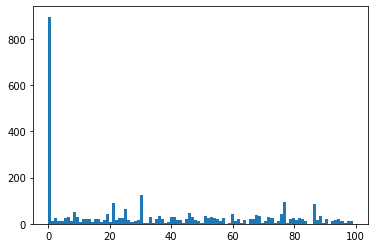

In [25]:
# Histogram of Movies per cluster
#f = pyplot.figure()
plt.hist(tags_cluster, bins=n_clusters);

We note that clusters contain less than 200 movies. There is however one outlier with over 800 movies. (Note: this is consistant across different clustering methods on this data.)

This outlier is  intriguing at the very least and bellow we inspect that cluster to better understand its content. 

For now, let us first explore the movies in difference clusters. 

In [26]:
#print(tags_cluster[:10])
for i in range(n_clusters):
    idx = np.where(tags_cluster == i)[0]
    print(f'\nCluster {i} (number of movies: {idx.size})')
    idx2 = tags_per_movie.iloc[idx].index
    display(movie_tags_cluster[movie_tags_cluster.mid.isin(idx2)][['mName', 'mGenres']])


Cluster 0 (number of movies: 896)


,mName,mGenres
3,Waiting to Exhale (1995),Comedy|Drama
11,Dracula: Dead and Loving It (1995),Comedy|Horror
17,Four Rooms (1995),Thriller
20,Get Shorty (1995),Action|Comedy|Drama
23,Powder (1995),Drama|Sci-Fi
30,Dangerous Minds (1995),Drama
32,Wings of Courage (1995),Adventure|Romance
36,Across the Sea of Time (1995),Documentary
37,It Takes Two (1995),Comedy
39,"Cry, the Beloved Country (1995)",Drama



Cluster 1 (number of movies: 10)


,mName,mGenres
95,Braveheart (1995),Action|Drama|War
257,"Shawshank Redemption, The (1994)",Drama
289,Forrest Gump (1994),Comedy|Romance|War
422,Schindler's List (1993),Drama|War
471,"Silence of the Lambs, The (1991)",Drama|Thriller
864,One Flew Over the Cuckoo's Nest (1975),Drama
1250,Good Will Hunting (1997),Drama
1416,Rain Man (1988),Drama
2158,American Beauty (1999),Comedy|Drama
2700,Gladiator (2000),Action|Drama



Cluster 2 (number of movies: 24)


,mName,mGenres
47,Pocahontas (1995),Animation|Children's|Musical|Romance
193,"Goofy Movie, A (1995)",Animation|Children's|Comedy|Romance
515,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy
535,Oliver & Company (1988),Animation|Children's
579,"Hunchback of Notre Dame, The (1996)",Animation|Children's|Musical
746,Winnie the Pooh and the Blustery Day (1968),Animation|Children's
747,"Three Caballeros, The (1945)",Animation|Children's|Musical
749,So Dear to My Heart (1949),Children's|Drama
753,Pete's Dragon (1977),Adventure|Animation|Children's|Musical
949,Fantasia (1940),Animation|Children's|Musical



Cluster 3 (number of movies: 11)


,mName,mGenres
31,Twelve Monkeys (1995),Drama|Sci-Fi
139,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
160,Strange Days (1995),Action|Crime|Sci-Fi
434,Blade Runner (1982),Film-Noir|Sci-Fi
1211,Gattaca (1997),Drama|Sci-Fi|Thriller
1272,Dark City (1998),Film-Noir|Sci-Fi|Thriller
1549,Tron (1982),Action|Adventure|Fantasy|Sci-Fi
1896,Westworld (1973),Action|Sci-Fi|Thriller|Western
1932,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2012,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller



Cluster 4 (number of movies: 11)


,mName,mGenres
155,"Show, The (1995)",Documentary
325,Above the Rim (1994),Drama
361,Fear of a Black Hat (1993),Comedy
378,House Party 3 (1994),Comedy
1091,Rhyme & Reason (1997),Documentary
1200,How to Be a Player (1997),Comedy
1351,I Got the Hook Up (1998),Comedy
1727,Belly (1998),Crime|Drama
2649,Black and White (1999),Drama
2852,House Party (1990),Comedy



Cluster 5 (number of movies: 24)


,mName,mGenres
43,Mortal Kombat (1995),Action|Adventure
97,Rumble in the Bronx (1995),Action|Adventure|Crime
319,Street Fighter (1994),Action
511,Bloodsport 2 (1995),Action
530,"Quest, The (1996)",Action|Adventure
623,Supercop (1992),Action|Thriller
712,In the Line of Duty 2 (1987),Action
1065,Jackie Chan's First Strike (1996),Action
1109,Double Team (1997),Action
1235,Mortal Kombat: Annihilation (1997),Action|Adventure



Cluster 6 (number of movies: 31)


,mName,mGenres
163,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
229,Nobody's Fool (1994),Drama
273,What's Eating Gilbert Grape (1993),Drama
565,Gold Diggers: The Secret of Bear Mountain (1995),Adventure|Children's
589,Lone Star (1996),Drama|Mystery
614,"Spitfire Grill, The (1996)",Drama
696,It's a Wonderful Life (1946),Drama
713,Picnic (1955),Drama
737,Pollyanna (1960),Children's|Comedy|Drama
906,Local Hero (1983),Comedy



Cluster 7 (number of movies: 10)


,mName,mGenres
267,Star Trek: Generations (1994),Action|Adventure|Sci-Fi
1013,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
1024,Star Trek: The Motion Picture (1979),Action|Adventure|Sci-Fi
1025,Star Trek VI: The Undiscovered Country (1991),Action|Adventure|Sci-Fi
1026,Star Trek V: The Final Frontier (1989),Action|Adventure|Sci-Fi
1027,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi
1028,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
1029,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi
1781,Star Trek: Insurrection (1998),Action|Sci-Fi
1972,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi



Cluster 8 (number of movies: 50)


,mName,mGenres
26,Now and Then (1995),Drama
34,Carrington (1995),Drama|Romance
84,Beautiful Girls (1996),Drama
114,"Brothers McMullen, The (1995)",Comedy
147,Moonlight and Valentino (1995),Drama|Romance
174,Boys on the Side (1995),Comedy|Drama
175,"Cure, The (1995)",Drama
186,Eat Drink Man Woman (1994),Comedy|Drama
490,My Favorite Season (1993),Drama
577,Stealing Beauty (1996),Drama



Cluster 9 (number of movies: 31)


,mName,mGenres
134,"Doom Generation, The (1995)",Comedy|Drama
510,Underground (1995),War
538,Dead Man (1995),Western
549,"Institute Benjamenta, or This Dream People Cal...",Drama
836,Faust (1994),Animation|Comedy|Thriller
850,Delicatessen (1991),Comedy|Sci-Fi
964,Pink Floyd - The Wall (1982),Drama|Musical|War
1087,Lost Highway (1997),Mystery
1154,Tetsuo II: Body Hammer (1992),Sci-Fi
1377,Pi (1998),Sci-Fi|Thriller



Cluster 10 (number of movies: 9)


,mName,mGenres
290,Four Weddings and a Funeral (1994),Comedy|Romance
1071,Benny & Joon (1993),Comedy|Romance
1086,That Old Feeling (1997),Comedy|Romance
1326,Kissing a Fool (1998),Comedy|Romance
1663,Working Girl (1988),Comedy|Drama
1868,Blast from the Past (1999),Comedy|Romance
2015,Twice Upon a Yesterday (1998),Comedy|Drama|Romance
2456,"Goodbye Girl, The (1977)",Comedy|Romance
2944,Love & Sex (2000),Comedy|Romance



Cluster 11 (number of movies: 20)


,mName,mGenres
150,Nine Months (1995),Comedy
498,Jack and Sarah (1995),Romance
523,Mrs. Winterbourne (1996),Comedy|Romance
602,"First Wives Club, The (1996)",Comedy
671,"Women, The (1939)",Comedy
1169,Picture Perfect (1997),Comedy|Romance
1232,"Joy Luck Club, The (1993)",Drama
1234,Sliding Doors (1998),Drama|Romance
1259,"Horse Whisperer, The (1998)",Drama
1353,Hope Floats (1998),Comedy|Drama|Romance



Cluster 12 (number of movies: 22)


,mName,mGenres
21,Copycat (1995),Crime|Drama|Thriller
337,Blink (1994),Thriller
385,Kalifornia (1993),Drama|Thriller
1012,Nightwatch (1997),Horror|Thriller
1188,Kiss the Girls (1997),Crime|Drama|Thriller
1219,Switchback (1997),Thriller
1596,"Henry: Portrait of a Serial Killer, Part 2 (1996)",Crime|Horror
1686,Clay Pigeons (1998),Crime
1830,In Dreams (1999),Thriller
1861,Peeping Tom (1960),Drama|Horror|Thriller



Cluster 13 (number of movies: 21)


,mName,mGenres
121,Batman Forever (1995),Action|Adventure|Comedy|Crime
426,"Shadow, The (1994)",Action
470,Batman (1989),Action|Adventure|Crime|Drama
569,"Phantom, The (1996)",Adventure
1030,Batman Returns (1992),Action|Adventure|Comedy|Crime
1149,Batman & Robin (1997),Action|Adventure|Crime
1167,Spawn (1997),Action|Adventure|Sci-Fi|Thriller
1173,Steel (1997),Action
1489,Condorman (1981),Action|Adventure|Children's|Comedy
1605,Blade (1998),Action|Adventure|Horror



Cluster 14 (number of movies: 6)


,mName,mGenres
118,Apollo 13 (1995),Drama
899,"Right Stuff, The (1983)",Drama
909,Glory (1989),Action|Drama|War
1244,Amistad (1997),Drama
2556,JFK (1991),Drama|Mystery
2834,"Patriot, The (2000)",Action|Drama|War



Cluster 15 (number of movies: 22)


,mName,mGenres
10,"American President, The (1995)",Comedy|Drama|Romance
13,Nixon (1995),Drama
88,City Hall (1996),Drama|Thriller
353,Dave (1993),Comedy|Romance
447,"War Room, The (1993)",Documentary
697,Mr. Smith Goes to Washington (1939),Drama
793,"Candidate, The (1972)",Drama
820,"Perfect Candidate, A (1996)",Documentary
846,Bob Roberts (1992),Comedy
934,"Manchurian Candidate, The (1962)",Film-Noir|Thriller



Cluster 16 (number of movies: 20)


,mName,mGenres
113,"Birdcage, The (1996)",Comedy
138,Jeffrey (1995),Comedy
260,Strawberry and Chocolate (Fresa y chocolate) (...,Drama
405,Philadelphia (1993),Drama
461,"Celluloid Closet, The (1995)",Documentary
603,Stonewall (1995),Drama
765,Beautiful Thing (1996),Drama|Romance
1134,Love! Valour! Compassion! (1997),Drama|Romance
1183,In & Out (1997),Comedy
1247,Bent (1997),Drama|War



Cluster 17 (number of movies: 6)


,mName,mGenres
0,Toy Story (1995),Animation|Children's|Comedy
1697,Antz (1998),Animation|Children's
1748,"Bug's Life, A (1998)",Animation|Children's|Comedy
2083,"Iron Giant, The (1999)",Animation|Children's
2367,Toy Story 2 (1999),Animation|Children's|Comedy
2399,Stuart Little (1999),Children's|Comedy



Cluster 18 (number of movies: 18)


,mName,mGenres
374,Heaven & Earth (1993),Action|Drama|War
800,Platoon (1986),Drama|War
852,Paths of Glory (1957),Drama|War
877,Apocalypse Now (1979),Drama|War
891,Full Metal Jacket (1987),Action|Drama|War
930,"Deer Hunter, The (1978)",Drama|War
965,"Killing Fields, The (1984)",Drama|War
1224,Welcome To Sarajevo (1997),Drama|War
1382,All Quiet on the Western Front (1930),War
1750,Savior (1998),Drama



Cluster 19 (number of movies: 43)


,mName,mGenres
38,Clueless (1995),Comedy|Romance
354,Dazed and Confused (1993),Comedy
527,Angus (1995),Comedy
545,"Craft, The (1996)",Drama|Horror
811,Rebel Without a Cause (1955),Drama
924,Better Off Dead... (1985),Comedy
935,Pump Up the Volume (1990),Drama
952,Heathers (1989),Comedy
957,Some Kind of Wonderful (1987),Drama|Romance
1033,Grease (1978),Comedy|Musical|Romance



Cluster 20 (number of movies: 8)


,mName,mGenres
140,Judge Dredd (1995),Action|Adventure|Sci-Fi
167,Waterworld (1995),Action|Adventure
355,Demolition Man (1993),Action|Sci-Fi
826,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
1719,Soldier (1998),Action|Adventure|Sci-Fi|Thriller|War
2263,Robocop (1987),Action|Crime|Sci-Fi
2794,Mad Max (1979),Action|Sci-Fi
2795,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi



Cluster 21 (number of movies: 92)


,mName,mGenres
5,Heat (1995),Action|Crime|Thriller
8,Sudden Death (1995),Action
19,Money Train (1995),Action
22,Assassins (1995),Thriller
65,Fair Game (1995),Action
85,Broken Arrow (1996),Action|Thriller
115,Bad Boys (1995),Action
131,Desperado (1995),Action|Romance|Thriller
133,Die Hard: With a Vengeance (1995),Action|Thriller
164,Under Siege 2: Dark Territory (1995),Action



Cluster 22 (number of movies: 15)


,mName,mGenres
282,Bullets Over Broadway (1994),Comedy
342,"Bronx Tale, A (1993)",Drama
795,Bonnie and Clyde (1967),Crime|Drama
815,"Funeral, The (1996)",Drama
896,Once Upon a Time in America (1984),Crime|Drama|Thriller
1174,Hoodlum (1997),Crime|Drama|Film-Noir
1666,My Blue Heaven (1990),Comedy
1907,Analyze This (1999),Comedy
1911,Six Ways to Sunday (1997),Comedy
2117,Mickey Blue Eyes (1999),Comedy|Romance



Cluster 23 (number of movies: 25)


,mName,mGenres
29,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
216,Legends of the Fall (1994),Drama|Romance|War|Western
539,"Horseman on the Roof, The (Hussard sur le toit...",Drama
667,Citizen Kane (1941),Drama
856,"English Patient, The (1996)",Drama|Romance|War
881,"Third Man, The (1949)",Mystery|Thriller
900,Stalker (1979),Mystery|Sci-Fi
915,Touch of Evil (1958),Crime|Film-Noir|Thriller
947,Raise the Red Lantern (1991),Drama
956,Koyaanisqatsi (1983),Documentary|War



Cluster 24 (number of movies: 24)


,mName,mGenres
177,Circle of Friends (1995),Drama|Romance
253,"Secret of Roan Inish, The (1994)",Drama
363,Widows' Peak (1994),Drama
382,In the Name of the Father (1993),Drama
518,"Run of the Country, The (1995)",Drama
571,"Last of the High Kings, The (a.k.a. Summer Fli...",Drama
719,Michael Collins (1996),Drama|War
854,Hear My Song (1991),Comedy
895,"Quiet Man, The (1952)",Comedy|Romance
1057,Some Mother's Son (1996),Drama



Cluster 25 (number of movies: 62)


,mName,mGenres
56,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
67,"Mis�rables, Les (1995)",Drama|Musical
154,"Scarlet Letter, The (1995)",Drama
184,Dolores Claiborne (1994),Drama|Thriller
204,Interview with the Vampire (1994),Drama|Horror
211,Little Women (1994),Drama
223,Mary Shelley's Frankenstein (1994),Drama|Horror
357,Even Cowgirls Get the Blues (1993),Comedy|Romance
365,"Firm, The (1993)",Drama|Thriller
429,"Simple Twist of Fate, A (1994)",Drama



Cluster 26 (number of movies: 18)


,mName,mGenres
59,Don't Be a Menace to South Central While Drink...,Comedy
301,Naked Gun 33 1/3: The Final Insult (1994),Comedy
375,Hot Shots! Part Deux (1993),Action|Comedy|War
416,Robin Hood: Men in Tights (1993),Comedy
558,Spy Hard (1996),Comedy
945,Young Frankenstein (1974),Comedy|Horror
1123,Austin Powers: International Man of Mystery (1...,Comedy
1478,Mafia! (1998),Comedy|Crime
1608,Wrongfully Accused (1998),Action|Comedy
1703,History of the World: Part I (1981),Comedy



Cluster 27 (number of movies: 9)


,mName,mGenres
233,Natural Born Killers (1994),Action|Thriller
235,Once Were Warriors (1994),Crime|Drama
394,Menace II Society (1993),Action|Crime|Drama
418,Romper Stomper (1992),Action|Drama
446,True Romance (1993),Action|Crime|Romance
875,"Clockwork Orange, A (1971)",Sci-Fi
1597,Henry: Portrait of a Serial Killer (1990),Crime|Horror
1724,American History X (1998),Drama
2478,Man Bites Dog (C'est arriv� pr�s de chez vous)...,Action|Comedy|Crime|Drama



Cluster 28 (number of movies: 11)


,mName,mGenres
415,Robocop 3 (1993),Sci-Fi|Thriller
494,All Dogs Go to Heaven 2 (1996),Animation|Children's|Musical
1039,Jaws 3-D (1983),Action|Horror
1148,Speed 2: Cruise Control (1997),Action|Romance|Thriller
1283,Blues Brothers 2000 (1998),Action|Comedy|Musical
1451,Poltergeist III (1988),Horror|Thriller
1453,Exorcist II: The Heretic (1977),Horror
1583,"American Tail: Fievel Goes West, An (1991)",Animation|Children's|Comedy
1796,Cocoon: The Return (1988),Comedy|Sci-Fi
2387,"Two Jakes, The (1990)",Drama



Cluster 29 (number of movies: 15)


,mName,mGenres
9,GoldenEye (1995),Action|Adventure|Thriller
1256,Tomorrow Never Dies (1997),Action|Romance|Thriller
1766,"View to a Kill, A (1985)",Action
2234,Goldfinger (1964),Action
2235,From Russia with Love (1963),Action
2236,Dr. No (1962),Action
2267,For Your Eyes Only (1981),Action
2268,Licence to Kill (1989),Action
2269,Live and Let Die (1973),Action
2271,Thunderball (1965),Action



Cluster 30 (number of movies: 124)


,mName,mGenres
63,Friday (1995),Comedy
80,Black Sheep (1996),Comedy
108,Down Periscope (1996),Comedy
145,Mallrats (1995),Comedy
178,Clerks (1994),Comedy
206,"Jerky Boys, The (1994)",Comedy
207,Junior (1994),Comedy|Sci-Fi
217,Major Payne (1994),Comedy
263,National Lampoon's Senior Trip (1995),Comedy
298,"Mask, The (1994)",Comedy|Crime|Fantasy



Cluster 31 (number of movies: 5)


,mName,mGenres
559,"Close Shave, A (1995)",Animation|Comedy|Thriller
833,"Wrong Trousers, The (1993)",Animation|Comedy
892,"Grand Day Out, A (1992)",Animation|Comedy
2583,Creature Comforts (1990),Animation|Comedy
2832,Chicken Run (2000),Animation|Children's|Comedy



Cluster 32 (number of movies: 2)


,mName,mGenres
621,"Godfather, The (1972)",Action|Crime|Drama
890,"Godfather: Part II, The (1974)",Action|Crime|Drama



Cluster 33 (number of movies: 29)


,mName,mGenres
384,Jurassic Park (1993),Action|Adventure|Sci-Fi
554,Twister (1996),Action|Adventure|Romance|Thriller
587,Daylight (1996),Action|Adventure|Thriller
1069,Dante's Peak (1997),Action|Thriller
1111,Anaconda (1997),Action|Adventure|Thriller
1122,Volcano (1997),Drama|Thriller
1140,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
1347,Godzilla (1998),Action|Sci-Fi
1466,"Poseidon Adventure, The (1972)",Action|Adventure
1700,What Dreams May Come (1998),Drama|Romance



Cluster 34 (number of movies: 2)


,mName,mGenres
870,Aliens (1986),Action|Sci-Fi|Thriller|War
883,Alien (1979),Action|Horror|Sci-Fi|Thriller



Cluster 35 (number of movies: 19)


,mName,mGenres
502,Mission: Impossible (1996),Action|Adventure|Mystery
673,Foreign Correspondent (1940),Thriller
674,Notorious (1946),Film-Noir|Romance|Thriller
704,"39 Steps, The (1935)",Thriller
1045,Sneakers (1992),Crime|Drama|Sci-Fi
1098,"Saint, The (1997)",Action|Romance|Thriller
1180,"Hunt for Red October, The (1990)",Action|Thriller
1196,"Assignment, The (1997)",Thriller
1617,Topaz (1969),Thriller
1618,Torn Curtain (1966),Thriller



Cluster 36 (number of movies: 33)


,mName,mGenres
110,Man of the Year (1995),Documentary
144,Love & Human Remains (1993),Comedy
240,Priest (1994),Drama
262,"Sum of Us, The (1994)",Comedy
279,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
314,"Man of No Importance, A (1994)",Drama
316,Boys Life (1995),Drama
323,Federal Hill (1994),Drama
371,Go Fish (1994),Drama|Romance
442,Threesome (1994),Comedy|Romance



Cluster 37 (number of movies: 20)


,mName,mGenres
18,Ace Ventura: When Nature Calls (1995),Comedy
60,Bio-Dome (1996),Comedy
91,Happy Gilmore (1996),Comedy
173,Billy Madison (1995),Comedy
185,Dumb & Dumber (1994),Comedy
271,Tommy Boy (1995),Comedy
278,Ace Ventura: Pet Detective (1994),Comedy
581,Kingpin (1996),Comedy
865,Up in Smoke (1978),Comedy
1067,Beverly Hills Ninja (1997),Action|Comedy



Cluster 38 (number of movies: 2)


,mName,mGenres
49,"Usual Suspects, The (1995)",Crime|Thriller
902,"Sting, The (1973)",Comedy|Crime



Cluster 39 (number of movies: 9)


,mName,mGenres
46,Seven (Se7en) (1995),Crime|Thriller
493,Primal Fear (1996),Drama|Thriller
1193,"Game, The (1997)",Mystery|Thriller
1275,Fallen (1998),Action|Mystery|Thriller
1297,Suicide Kings (1997),Crime|Drama
1299,Wild Things (1998),Crime|Drama|Mystery|Thriller
1317,"Spanish Prisoner, The (1997)",Drama|Thriller
2041,Arlington Road (1999),Thriller
2313,Dead Again (1991),Mystery|Romance|Thriller



Cluster 40 (number of movies: 31)


,mName,mGenres
107,Jade (1995),Thriller
156,Showgirls (1995),Drama
236,Poison Ivy II (1995),Thriller
281,Bitter Moon (1992),Drama
341,Boxing Helena (1993),Mystery|Romance|Thriller
350,Color of Night (1994),Drama|Thriller
396,In the Realm of the Senses (Ai no corrida) (1976),Drama
430,Sirens (1994),Comedy|Drama
433,Sliver (1993),Thriller
449,"Paris, France (1993)",Comedy



Cluster 41 (number of movies: 30)


,mName,mGenres
24,Leaving Las Vegas (1995),Drama|Romance
55,"Postino, Il (The Postman) (1994)",Drama|Romance
96,Taxi Driver (1976),Drama|Thriller
103,Chungking Express (1994),Drama|Mystery|Romance
161,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical
187,Exotica (1994),Drama
247,Three Colors: Red (1994),Drama
248,Three Colors: Blue (1993),Drama
437,Harlem (1993),Drama
528,Daens (1992),Drama



Cluster 42 (number of movies: 18)


,mName,mGenres
12,Balto (1995),Animation|Children's
252,"Swan Princess, The (1994)",Animation|Children's
755,Alice in Wonderland (1951),Animation|Children's|Musical
756,"Fox and the Hound, The (1981)",Animation|Children's
1106,Cats Don't Dance (1997),Animation|Children's|Musical
1241,Anastasia (1997),Animation|Children's|Musical
1346,Quest for Camelot (1998),Adventure|Animation|Children's|Fantasy
1534,"Rescuers Down Under, The (1990)",Animation|Children's
1567,All Dogs Go to Heaven (1989),Animation|Children's
1582,"American Tail, An (1986)",Animation|Children's|Comedy



Cluster 43 (number of movies: 15)


,mName,mGenres
504,Dragonheart (1996),Action|Adventure|Fantasy
867,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
1163,Conan the Barbarian (1982),Action|Adventure
1422,Labyrinth (1986),Adventure|Children's|Fantasy
1581,"Dark Crystal, The (1982)",Children's|Fantasy|Sci-Fi
1584,Legend (1985),Adventure|Fantasy|Romance
1599,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy
1600,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy
1629,Willow (1988),Action|Adventure|Fantasy
2065,"Golden Child, The (1986)",Action|Adventure|Comedy



Cluster 44 (number of movies: 2)


,mName,mGenres
1938,Following (1998),Drama
1946,Open Your Eyes (Abre los ojos) (1997),Drama|Romance|Sci-Fi



Cluster 45 (number of movies: 21)


,mName,mGenres
227,Miracle on 34th Street (1994),Drama
256,"Santa Clause, The (1994)",Children's|Comedy|Fantasy
410,"Ref, The (1994)",Comedy
443,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical
465,Home Alone (1990),Children's|Comedy
808,"Christmas Carol, A (1938)",Drama
975,Santa with Muscles (1996),Comedy
1016,Jingle All the Way (1996),Adventure|Children's|Comedy
1528,"Muppet Christmas Carol, The (1992)",Children's|Musical
1531,One Magic Christmas (1985),Drama|Fantasy



Cluster 46 (number of movies: 46)


,mName,mGenres
2,Grumpier Old Men (1995),Comedy|Romance
4,Father of the Bride Part II (1995),Comedy
322,Highlander III: The Sorcerer (1994),Action|Sci-Fi
326,Addams Family Values (1993),Comedy
346,City Slickers II: The Legend of Curly's Gold (...,Comedy|Western
481,Candyman: Farewell to the Flesh (1995),Horror
598,"Very Brady Sequel, A (1996)",Comedy
610,"Crow: City of Angels, The (1996)",Action|Thriller
734,Herbie Rides Again (1974),Adventure|Children's|Comedy
781,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy



Cluster 47 (number of movies: 31)


,mName,mGenres
81,Nick of Time (1995),Action|Thriller
148,Mute Witness (1994),Thriller
368,"Fugitive, The (1993)",Action|Thriller
381,In the Line of Fire (1993),Action|Thriller
604,Ransom (1996),Drama|Thriller
647,Vertigo (1958),Mystery|Thriller
648,Rear Window (1954),Mystery|Thriller
650,Gaslight (1944),Mystery|Thriller
652,North by Northwest (1959),Drama|Thriller
888,Psycho (1960),Horror|Thriller



Cluster 48 (number of movies: 17)


,mName,mGenres
190,French Kiss (1995),Comedy|Romance
203,I.Q. (1994),Comedy|Romance
275,While You Were Sleeping (1995),Comedy|Romance
432,Sleepless in Seattle (1993),Comedy|Romance
475,Pretty Woman (1990),Comedy|Romance
534,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
973,When Harry Met Sally... (1989),Comedy|Romance
1010,"Mirror Has Two Faces, The (1996)",Comedy|Romance
1081,Fools Rush In (1997),Comedy|Romance
1153,My Best Friend's Wedding (1997),Comedy|Romance



Cluster 49 (number of movies: 14)


,mName,mGenres
201,Heavyweights (1994),Children's|Comedy
929,"Great Escape, The (1963)",Adventure|War
1519,"Night Porter, The (Il Portiere di notte) (1974)",Drama
1720,Life Is Beautiful (La Vita � bella) (1997),Comedy|Drama
1982,Mommie Dearest (1981),Drama
2294,Piranha (1978),Horror|Sci-Fi
2309,Meatballs (1979),Comedy
2310,Meatballs Part II (1984),Comedy
2311,Meatballs III (1987),Comedy
2312,Meatballs 4 (1992),Comedy



Cluster 50 (number of movies: 2)


,mName,mGenres
468,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
907,"Terminator, The (1984)",Action|Sci-Fi|Thriller



Cluster 51 (number of movies: 32)


,mName,mGenres
7,Tom and Huck (1995),Adventure|Children's
14,Cutthroat Island (1995),Action|Adventure|Romance
128,Congo (1995),Action|Adventure|Mystery|Sci-Fi
136,Free Willy 2: The Adventure Home (1995),Adventure|Children's|Drama
293,"Jungle Book, The (1994)",Adventure|Children's|Romance
444,"Three Musketeers, The (1993)",Action|Adventure|Comedy
448,"Pagemaster, The (1994)",Action|Adventure|Animation|Children's|Fantasy
566,Kim (1950),Children's|Drama
683,"Adventures of Robin Hood, The (1938)",Action|Adventure
708,"African Queen, The (1951)",Action|Adventure|Romance|War



Cluster 52 (number of movies: 27)


,mName,mGenres
989,April Fool's Day (1986),Comedy|Horror
999,Candyman (1992),Horror
1053,Scream (1996),Horror|Thriller
1204,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller
1428,Freddy's Dead: The Final Nightmare (1991),Horror
1439,Halloween III: Season of the Witch (1983),Horror
1442,Prom Night (1980),Horror
1443,Hello Mary Lou: Prom Night II (1987),Horror
1444,Prom Night III: The Last Kiss (1989),Horror
1445,Prom Night IV: Deliver Us From Evil (1992),Horror



Cluster 53 (number of movies: 29)


,mName,mGenres
158,Species (1995),Horror|Sci-Fi
408,Robert A. Heinlein's The Puppet Masters (1994),Horror|Sci-Fi
562,"Arrival, The (1996)",Action|Sci-Fi|Thriller
576,Independence Day (ID4) (1996),Action|Sci-Fi|War
824,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
920,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
979,Alien� (1992),Action|Horror|Sci-Fi|Thriller
1041,Mars Attacks! (1996),Action|Comedy|Sci-Fi|War
1158,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
1161,Contact (1997),Drama|Sci-Fi



Cluster 54 (number of movies: 25)


,mName,mGenres
52,Georgia (1995),Drama
58,Mr. Holland's Opus (1995),Drama
280,Backbeat (1993),Drama|Musical
441,Thirty-Two Short Films About Glenn Gould (1993),Documentary
585,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary
626,Kansas City (1996),Crime
762,That Thing You Do! (1996),Comedy
889,"Blues Brothers, The (1980)",Action|Comedy|Musical
974,Hype! (1996),Documentary
1014,Shine (1996),Drama|Romance



Cluster 55 (number of movies: 19)


,mName,mGenres
25,Othello (1995),Drama
40,Richard III (1995),Drama|War
86,In the Bleak Midwinter (1995),Comedy
398,Much Ado About Nothing (1993),Comedy|Romance
638,Twelfth Night (1996),Comedy|Drama|Romance
768,Looking for Richard (1996),Documentary|Drama
776,William Shakespeare's Romeo and Juliet (1996),Drama|Romance
893,Henry V (1989),Drama|War
910,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama
1056,Hamlet (1996),Drama



Cluster 56 (number of movies: 13)


,mName,mGenres
243,Queen Margot (La Reine Margot) (1994),Drama|Romance
328,"Age of Innocence, The (1993)",Drama
962,"Room with a View, A (1986)",Drama|Romance
1203,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",Drama|Romance
1209,Washington Square (1997),Drama
1237,"Wings of the Dove, The (1997)",Drama|Romance|Thriller
1635,Under Capricorn (1949),Drama
1731,Elizabeth (1998),Drama
2026,"Ideal Husband, An (1999)",Comedy
2403,Onegin (1999),Drama



Cluster 57 (number of movies: 25)


,mName,mGenres
6,Sabrina (1995),Comedy|Romance
68,Bed of Roses (1996),Drama|Romance
101,If Lucy Fell (1996),Comedy|Romance
112,Up Close and Personal (1996),Drama|Romance
191,Forget Paris (1995),Comedy|Romance
234,Only You (1994),Comedy|Romance
292,It Could Happen to You (1994),Drama|Romance
308,Speechless (1994),Comedy|Romance
364,For Love or Money (1993),Comedy
480,One Fine Day (1996),Drama|Romance



Cluster 58 (number of movies: 1)


,mName,mGenres
2242,Fight Club (1999),Drama



Cluster 59 (number of movies: 2)


,mName,mGenres
919,Chinatown (1974),Film-Noir|Mystery|Thriller
951,"Big Sleep, The (1946)",Film-Noir|Mystery



Cluster 60 (number of movies: 42)


,mName,mGenres
51,"Big Green, The (1995)",Children's|Comedy
198,Hoop Dreams (1994),Documentary
287,Cobb (1994),Drama
330,"Air Up There, The (1994)",Comedy
339,Blue Chips (1994),Drama
407,"Program, The (1993)",Action|Drama
420,Rudy (1993),Drama
423,"Scout, The (1994)",Drama
456,Little Big League (1994),Children's|Comedy
505,Eddie (1996),Comedy



Cluster 61 (number of movies: 11)


,mName,mGenres
15,Casino (1995),Drama|Thriller
74,Things to Do in Denver when You're Dead (1995),Crime|Drama|Romance
345,Carlito's Way (1993),Crime|Drama
624,Bound (1996),Crime|Drama|Romance|Thriller
882,GoodFellas (1990),Crime|Drama
912,Miller's Crossing (1990),Drama
1089,Donnie Brasco (1997),Crime|Drama
1261,Jackie Brown (1997),Crime|Drama
1289,King of New York (1990),Action|Crime
1630,"Untouchables, The (1987)",Action|Crime|Drama



Cluster 62 (number of movies: 19)


,mName,mGenres
70,Screamers (1995),Sci-Fi|Thriller
309,Timecop (1994),Action|Sci-Fi
759,"Lawnmower Man, The (1992)",Action|Sci-Fi|Thriller
937,Back to the Future (1985),Comedy|Sci-Fi
1129,"Fifth Element, The (1997)",Action|Sci-Fi
1230,Starship Troopers (1997),Action|Adventure|Sci-Fi|War
1462,Soylent Green (1973),Sci-Fi|Thriller
1463,Metropolis (1926),Sci-Fi
1464,Back to the Future Part II (1989),Comedy|Sci-Fi
1465,Back to the Future Part III (1990),Comedy|Sci-Fi|Western



Cluster 63 (number of movies: 2)


,mName,mGenres
239,Pulp Fiction (1994),Crime|Drama
799,Reservoir Dogs (1992),Crime|Thriller



Cluster 64 (number of movies: 18)


,mName,mGenres
64,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
553,Cemetery Man (Dellamorte Dellamore) (1994),Comedy|Horror
707,Night of the Living Dead (1968),Horror|Sci-Fi
884,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi
908,Braindead (1992),Comedy|Horror
922,Bad Taste (1987),Comedy|Horror
928,Evil Dead II (Dead By Dawn) (1987),Action|Adventure|Comedy|Horror
1842,"Texas Chainsaw Massacre, The (1974)",Horror
2196,Phantasm (1979),Horror|Sci-Fi
2289,Re-Animator (1985),Horror



Cluster 65 (number of movies: 1)


,mName,mGenres
874,Lawrence of Arabia (1962),Adventure|War



Cluster 66 (number of movies: 21)


,mName,mGenres
568,Stalingrad (1993),War
901,"Boat, The (Das Boot) (1981)",Action|Drama|War
917,"Bridge on the River Kwai, The (1957)",Drama|War
939,Patton (1970),Drama|War
1391,Mrs. Miniver (1942),Drama|War
1479,Saving Private Ryan (1998),Action|Drama|War
1821,Tea with Mussolini (1999),Comedy
2010,"Run Silent, Run Deep (1958)",War
2232,"Dirty Dozen, The (1967)",Action|War
2304,Mister Roberts (1955),Comedy|Drama|War



Cluster 67 (number of movies: 19)


,mName,mGenres
637,Halloween: The Curse of Michael Myers (1995),Horror|Thriller
1004,"Nightmare on Elm Street, A (1984)",Horror
1424,Nightmare on Elm Street Part 2: Freddy's Reven...,Horror
1425,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror
1426,"Nightmare on Elm Street 4: The Dream Master, A...",Horror
1427,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror
1429,Friday the 13th (1980),Horror
1430,Friday the 13th Part 2 (1981),Horror
1431,Friday the 13th Part 3: 3D (1982),Horror
1432,Friday the 13th: The Final Chapter (1984),Horror



Cluster 68 (number of movies: 36)


,mName,mGenres
469,Dances with Wolves (1990),Adventure|Drama|Western
653,"Apartment, The (1960)",Comedy|Drama
658,My Fair Lady (1964),Musical|Romance
664,Gone with the Wind (1939),Drama|Romance|War
691,Giant (1956),Drama
695,Around the World in 80 Days (1956),Adventure|Comedy
821,On Golden Pond (1981),Drama
858,My Left Foot (1989),Drama
897,Raging Bull (1980),Drama
898,Annie Hall (1977),Comedy|Romance



Cluster 69 (number of movies: 32)


,mName,mGenres
92,"Bridges of Madison County, The (1995)",Drama|Romance
166,"Walk in the Clouds, A (1995)",Drama|Romance
172,Before Sunrise (1995),Drama|Romance
179,Don Juan DeMarco (1995),Comedy|Drama|Romance
220,Love Affair (1994),Drama|Romance
466,Ghost (1990),Comedy|Romance|Thriller
646,Breakfast at Tiffany's (1961),Drama|Romance
676,"Affair to Remember, An (1957)",Romance
681,Love in the Afternoon (1957),Comedy|Romance
686,"Ghost and Mrs. Muir, The (1947)",Drama|Romance



Cluster 70 (number of movies: 5)


,mName,mGenres
886,Ran (1985),Drama|War
1470,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
2200,Sanjuro (1962),Action|Adventure
2299,Yojimbo (1961),Comedy|Drama|Western
2347,Kagemusha (1980),Drama|War



Cluster 71 (number of movies: 12)


,mName,mGenres
488,"Flower of My Secret, The (La Flor de Mi Secret...",Drama
541,Mouth to Mouth (Boca a boca) (1995),Comedy
584,"I, Worst of All (Yo, la peor de todas) (1990)",Drama
1294,"Callej�n de los milagros, El (1995)",Drama
1322,Live Flesh (1997),Drama
1943,"Lovers of the Arctic Circle, The (Los Amantes ...",Drama|Romance
2204,"Grandfather, The (El Abuelo) (1998)",Drama
2329,Women on the Verge of a Nervous Breakdown (1988),Comedy|Drama
2341,All About My Mother (Todo Sobre Mi Madre) (1999),Comedy|Drama
2829,Butterfly (La Lengua de las Mariposas) (2000),Drama|War



Cluster 72 (number of movies: 29)


,mName,mGenres
35,Dead Man Walking (1995),Drama
413,Rising Sun (1993),Action|Drama|Mystery
675,Spellbound (1945),Mystery|Romance|Thriller
685,Laura (1944),Crime|Film-Noir|Mystery
693,"Thin Man, The (1934)",Mystery
784,Crossfire (1947),Crime|Film-Noir
785,"Murder, My Sweet (1944)",Film-Noir|Thriller
797,Dial M for Murder (1954),Mystery|Thriller
837,He Walked by Night (1948),Crime|Film-Noir|Thriller
861,"Thin Blue Line, The (1988)",Documentary



Cluster 73 (number of movies: 23)


,mName,mGenres
33,Babe (1995),Children's|Comedy|Drama
192,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children's
195,Fluke (1995),Children's|Drama
460,Andre (1994),Adventure|Children's
483,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children's
735,Old Yeller (1957),Children's|Drama
738,Homeward Bound: The Incredible Journey (1993),Adventure|Children's
1021,101 Dalmatians (1996),Children's|Comedy
1064,Zeus and Roxanne (1997),Children's
1136,"Second Jungle Book: Mowgli & Baloo, The (1997)",Adventure|Children's



Cluster 74 (number of movies: 2)


,mName,mGenres
28,"City of Lost Children, The (1995)",Adventure|Sci-Fi
869,Brazil (1985),Sci-Fi



Cluster 75 (number of movies: 11)


,mName,mGenres
57,Eye for an Eye (1996),Drama|Thriller
286,"Crow, The (1994)",Action|Romance|Thriller
593,"Time to Kill, A (1996)",Drama
778,Sleepers (1996),Crime|Drama
1862,Payback (1999),Action|Thriller
2212,High Plains Drifter (1972),Western
2213,Hang 'em High (1967),Western
2291,Falling Down (1993),Action|Drama
2487,"Boondock Saints, The (1999)",Action|Comedy
2584,Death Wish (1974),Action|Drama



Cluster 76 (number of movies: 42)


,mName,mGenres
71,Nico Icon (1995),Documentary
506,Billy's Holiday (1995),Drama
643,Singin' in the Rain (1952),Musical|Romance
644,"American in Paris, An (1951)",Musical|Romance
645,Funny Face (1957),Comedy|Musical
651,"Gay Divorcee, The (1934)",Comedy|Musical|Romance
679,"Band Wagon, The (1953)",Comedy|Musical
688,Top Hat (1935),Comedy|Musical|Romance
757,"Sound of Music, The (1965)",Musical
774,Everyone Says I Love You (1996),Comedy|Musical|Romance



Cluster 77 (number of movies: 96)


,mName,mGenres
83,Vampire in Brooklyn (1995),Comedy|Romance
143,Lord of Illusions (1995),Horror
176,Castle Freak (1995),Horror
266,Tales From the Crypt Presents: Demon Knight (1...,Horror
268,Tales from the Hood (1995),Comedy|Horror
297,Wes Craven's New Nightmare (1994),Horror
312,Wolf (1994),Drama|Horror
321,"Fear, The (1995)",Horror
324,In the Mouth of Madness (1995),Horror|Thriller
454,Cronos (1992),Horror



Cluster 78 (number of movies: 3)


,mName,mGenres
210,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
866,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
879,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War



Cluster 79 (number of movies: 21)


,mName,mGenres
295,"Lion King, The (1994)",Animation|Children's|Musical
467,Aladdin (1992),Animation|Children's|Comedy|Musical
472,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
473,Beauty and the Beast (1991),Animation|Children's|Musical
474,Pinocchio (1940),Animation|Children's
487,"Aristocats, The (1970)",Animation|Children's
745,Cinderella (1950),Animation|Children's|Musical
748,"Sword in the Stone, The (1963)",Animation|Children's
752,Dumbo (1941),Animation|Children's|Musical
1366,Mulan (1998),Animation|Children's



Cluster 80 (number of movies: 24)


,mName,mGenres
169,Wild Bill (1995),Western
244,"Quick and the Dead, The (1995)",Action|Adventure|Western
313,Wyatt Earp (1994),Western
445,Tombstone (1993),Western
477,"Wild Bunch, The (1969)",Western
703,Angel and the Badman (1947),Western
706,"Outlaw, The (1943)",Western
871,"Good, The Bad and The Ugly, The (1966)",Action|Western
878,Once Upon a Time in the West (1969),Western
950,High Noon (1952),Western



Cluster 81 (number of movies: 18)


,mName,mGenres
200,Immortal Beloved (1994),Drama|Romance
383,What's Love Got to Do with It? (1993),Drama
617,Basquiat (1996),Drama
803,"Doors, The (1991)",Drama|Musical
818,"People vs. Larry Flynt, The (1996)",Drama
960,Gandhi (1982),Drama
1072,Prefontaine (1997),Drama
1096,Private Parts (1997),Comedy|Drama
1246,Artemisia (1997),Drama
1286,Ayn Rand: A Sense of Life (1997),Documentary



Cluster 82 (number of movies: 25)


,mName,mGenres
1,Jumanji (1995),Adventure|Children's|Fantasy
53,Kids of the Round Table (1995),Adventure|Children's|Fantasy
73,"White Balloon, The (Badkonake Sefid ) (1995)",Drama
126,Casper (1995),Adventure|Children's
305,Richie Rich (1994),Children's|Comedy
366,Free Willy (1993),Adventure|Children's|Drama
388,Lassie (1994),Adventure|Children's
459,"Little Rascals, The (1994)",Children's|Comedy
608,Matilda (1996),Children's|Comedy
732,Escape to Witch Mountain (1975),Adventure|Children's|Fantasy



Cluster 83 (number of movies: 19)


,mName,mGenres
146,Mighty Morphin Power Rangers: The Movie (1995),Action|Children's
334,"Beverly Hillbillies, The (1993)",Comedy
464,"Brady Bunch Movie, The (1995)",Comedy
497,Sgt. Bilko (1996),Comedy
1073,McHale's Navy (1997),Comedy|War
1107,Turbo: A Power Rangers Movie (1997),Action|Adventure|Children's
1164,George of the Jungle (1997),Children's|Comedy
1175,Leave It to Beaver (1997),Comedy
1568,"Addams Family, The (1991)",Comedy
1593,"Avengers, The (1998)",Action|Adventure



Cluster 84 (number of movies: 12)


,mName,mGenres
109,From the Journals of Jean Seberg (1995),Documentary
130,Crumb (1994),Documentary
294,"Wonderful, Horrible Life of Leni Riefenstahl, ...",Documentary
478,"Great Day in Harlem, A (1994)",Documentary
813,Microcosmos (Microcosmos: Le peuple de l'herbe...,Documentary
978,Paris Was a Woman (1995),Documentary
1507,Full Tilt Boogie (1997),Documentary
1510,Roger & Me (1989),Comedy|Documentary
1725,Hands on a Hard Body (1996),Documentary
2219,Return with Honor (1998),Documentary



Cluster 85 (number of movies: 1)


,mName,mGenres
2084,"Sixth Sense, The (1999)",Thriller



Cluster 86 (number of movies: 1)


,mName,mGenres
894,Amadeus (1984),Drama



Cluster 87 (number of movies: 85)


,mName,mGenres
87,"Hate (Haine, La) (1995)",Drama
122,Belle de jour (1967),Drama
171,Before the Rain (Pred dozhdot) (1994),Drama
249,Three Colors: White (1994),Drama
387,King of the Hill (1993),Drama
428,Short Cuts (1993),Drama
507,Purple Noon (1960),Crime|Thriller
512,Pather Panchali (1955),Drama
513,"World of Apu, The (Apur Sansar) (1959)",Drama
519,Alphaville (1965),Sci-Fi



Cluster 88 (number of movies: 17)


,mName,mGenres
16,Sense and Sensibility (1995),Drama|Romance
27,Persuasion (1995),Romance
42,Restoration (1995),Drama
119,Rob Roy (1995),Drama|Romance|War
196,Farinelli: il castrato (1994),Drama|Musical
205,Jefferson in Paris (1995),Drama
222,"Madness of King George, The (1994)",Drama
404,Orlando (1993),Drama
609,Emma (1996),Comedy|Drama|Romance
944,Cyrano de Bergerac (1990),Action|Drama|Romance



Cluster 89 (number of movies: 32)


,mName,mGenres
78,White Squall (1996),Adventure|Drama
392,"Man Without a Face, The (1993)",Drama
424,Searching for Bobby Fischer (1993),Drama
847,Cinema Paradiso (1988),Comedy|Drama|Romance
913,Dead Poets Society (1989),Drama
942,Highlander (1986),Action|Adventure
963,Real Genius (1985),Comedy
966,My Life as a Dog (Mitt liv som hund) (1985),Drama
1226,"Rainmaker, The (1997)",Drama
1330,Character (Karakter) (1997),Drama



Cluster 90 (number of movies: 2)


,mName,mGenres
791,Monty Python's Life of Brian (1979),Comedy
831,Monty Python and the Holy Grail (1974),Comedy



Cluster 91 (number of movies: 21)


,mName,mGenres
99,Anne Frank Remembered (1995),Documentary
639,Mother Night (1996),Drama
656,Casablanca (1942),Drama|Romance|War
669,Golden Earrings (1947),Adventure|Romance
689,To Be or Not to Be (1942),Comedy|Drama|War
840,"Tin Drum, The (Blechtrommel, Die) (1979)",Drama
948,"Great Dictator, The (1940)",Comedy
1520,Mephisto (1981),Drama|War
1550,Swing Kids (1993),Drama|War
1717,Apt Pupil (1998),Drama|Thriller



Cluster 92 (number of movies: 1)


,mName,mGenres
1400,On the Waterfront (1954),Crime|Drama



Cluster 93 (number of movies: 14)


,mName,mGenres
116,"Basketball Diaries, The (1995)",Drama
574,Trainspotting (1996),Drama
633,Sweet Nothing (1995),Drama
1075,Gridlock'd (1997),Crime
1349,Fear and Loathing in Las Vegas (1998),Comedy|Drama
1680,Permanent Midnight (1998),Drama
1741,Sid and Nancy (1986),Drama
1824,Another Day in Paradise (1998),Drama
2290,Drugstore Cowboy (1989),Crime|Drama
2484,Bad Lieutenant (1992),Crime|Drama



Cluster 94 (number of movies: 15)


,mName,mGenres
482,Fargo (1996),Crime|Drama|Thriller
649,It Happened One Night (1934),Comedy
666,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
670,All About Eve (1950),Drama
812,"Streetcar Named Desire, A (1951)",Drama
873,12 Angry Men (1957),Drama
921,"Treasure of the Sierra Madre, The (1948)",Adventure
943,Cool Hand Luke (1967),Comedy|Drama
1015,Sling Blade (1996),Drama|Thriller
1186,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller



Cluster 95 (number of movies: 19)


,mName,mGenres
516,Barbarella (1968),Adventure|Sci-Fi
1285,Sphere (1998),Adventure|Sci-Fi|Thriller
1692,Them! (1954),Sci-Fi|Thriller|War
1832,Virus (1999),Horror|Sci-Fi
1895,Meteor (1979),Sci-Fi
1899,Beneath the Planet of the Apes (1970),Action|Sci-Fi
1937,"Sticky Fingers of Time, The (1997)",Sci-Fi
1961,My Science Project (1985),Adventure|Sci-Fi
1998,Tarantula (1955),Horror|Sci-Fi
2003,It Came from Beneath the Sea (1955),Sci-Fi



Cluster 96 (number of movies: 13)


,mName,mGenres
255,Stargate (1994),Action|Adventure|Sci-Fi
668,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
967,Forbidden Planet (1956),Sci-Fi
1166,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller
1314,Lost in Space (1998),Action|Sci-Fi|Thriller
1483,"Black Hole, The (1979)",Sci-Fi
1710,2010 (1984),Mystery|Sci-Fi
1898,Planet of the Apes (1968),Action|Sci-Fi
2424,Supernova (2000),Adventure|Sci-Fi
2537,Mission to Mars (2000),Sci-Fi



Cluster 97 (number of movies: 2)


,mName,mGenres
1342,Deep Impact (1998),Action|Drama|Sci-Fi|Thriller
1373,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller



Cluster 98 (number of movies: 12)


,mName,mGenres
611,Eyes Without a Face (1959),Horror
1859,"Day of the Beast, The (El D�a de la bestia) (1...",Comedy|Horror|Thriller
1923,Ravenous (1999),Drama|Horror
2100,"Tomb of Ligeia, The (1965)",Horror
2102,Tales of Terror (1962),Horror
2435,Black Sunday (La Maschera Del Demonio) (1960),Horror
2620,Horror Hotel (a.k.a. The City of the Dead) (1960),Horror
2704,Inferno (1980),Horror
2730,Carnival of Souls (1962),Horror|Thriller
2838,Asylum (1972),Horror



Cluster 99 (number of movies: 11)


,mName,mGenres
369,Geronimo: An American Legend (1993),Drama|Western
731,"Davy Crockett, King of the Wild Frontier (1955)",Western
1054,"Last of the Mohicans, The (1992)",Action|Romance|War
1257,"Education of Little Tree, The (1997)",Drama
1372,Smoke Signals (1998),Comedy|Drama
1546,Squanto: A Warrior's Tale (1994),Adventure|Drama
1760,"Emerald Forest, The (1985)",Action|Adventure|Drama
2071,"Mission, The (1986)",Drama
2306,Little Big Man (1970),Comedy|Drama|Western
2334,Jeremiah Johnson (1972),Western


Above we note that the clusters seem to "make sense". If you know some of these movies it will be clear that clusters are coherent. If not, then the genre column is a reasonable proxy (note that clusters tend to have fairly homogeneous genres).  

Now, what about that very large cluster. Let us examine it to understand how it came about. 

In [27]:
large_cluster_id = np.argmax(np.bincount(tags_cluster))
idx = np.where(tags_cluster == large_cluster_id)[0]

idx2 = movie_tags_cluster.iloc[idx].mid
display(tags_high_names_movies[tags_high_names_movies.mid.isin(idx2)].sort_values(by=['mid']))

,mid,tid,relevance,tName,mName,mGenres
5391,4,1116,0.97675,women,Waiting to Exhale (1995),Comedy|Drama
9998,12,958,0.99675,spoof,Dracula: Dead and Loving It (1995),Comedy|Horror
9997,12,770,0.98900,parody,Dracula: Dead and Loving It (1995),Comedy|Horror
11049,18,735,0.92675,off-beat comedy,Four Rooms (1995),Thriller
11050,18,972,0.91200,storytelling,Four Rooms (1995),Thriller
1038,21,469,0.90225,great movie,Get Shorty (1995),Action|Comedy|Drama
1039,21,658,0.95450,mob,Get Shorty (1995),Action|Comedy|Drama
11639,24,1035,0.96675,touching,Powder (1995),Drama|Sci-Fi
12914,31,503,0.90950,high school,Dangerous Minds (1995),Drama
12915,31,1010,0.95450,teacher,Dangerous Minds (1995),Drama


This list does not provide much clarity but confirms that the movies in this cluster do not seem to belong. 

One possibility is that we just don't have enough tag information about these movies to cluster them accurately. Below we show that while the average movie received 5.3 tags on average, movies in this cluster only receive an average of 2.4 tags.

Furthermore, the tags in this cluster seem to be slightly more popular (17.4 movies) than the average tag (16.3 movies). So that does not seem to be a factor.

In [28]:
# look at average number of tags of movies in this cluster versus in other clusters
print('Average number of tags for movie from the last cluster %.2f' % 
      tags_high_names_movies[tags_high_names_movies.mid.isin(idx2)].groupby('mid').count().mean()[0])
print('Average number of tags for all movies %.2f' %
      tags_high_names_movies.groupby('mid').count().mean()[0])

print()
# examine the tags themselves. Number of tags per Are they rare tags? 
print('Average number of movies for tags in the large cluster %.2f' %
      tags_high_names_movies[tags_high_names_movies.tid.isin(idx2)].groupby('tid').count().mean()[0])
print('Average number of movies for all tags %.2f' %
      tags_high_names_movies.groupby('tid').count().mean()[0])

Average number of tags for movie from the last cluster 2.43
Average number of tags for all movies 5.26

Average number of movies for tags in the large cluster 15.93
Average number of movies for all tags 16.29


#### Clustering remarks

- Above we ran a clustering method to cluster movies according to their tags. 
- We noticed that while most movies were reasonably clustered, a reasonably large number of movies belonged to a single (large) cluster. 
- Recall that movie tag representations are very sparse vectors. As such, two movies with a small number of tags may actually be close to one another according to most metrics. 

##### Question

- What would you suggest to obtain better clusters? 
- One possibility is to represent movies by their genres. It is likely that there many fewer genres than tags. As such, the clustering could be more meaningful. One could get the best of both worlds by using both tags and genres to cluster movies. Run and analyze such a clustering. 


In [29]:
# for later we add the clustering results to our main dataFrame
tags_per_movie['tcluster'] = tags_cluster

### Prepare dataset

In the next few steps we further pre-process our data in order to create a dataset for supervised learning. Recall, that we wish to predict user-movie preferences from user and movie features. 

In [30]:
# Join users, ratings, and tags
data_pd = pd.merge(users_pd, ratings_pd, how='inner', on='uid')
data_pd = pd.merge(data_pd, tags_per_movie, how='inner', on='mid')

print('Final descriptive stats of our dataset.')
print('\t- %d items'   % data_pd['mid'].nunique())
print('\t- %d users'   % data_pd['uid'].nunique())
print('\t- %d ratings' % data_pd.shape[0])

Final descriptive stats of our dataset.
	- 2998 items
	- 6040 users
	- 962760 ratings


For the purpose of this tutorial, we will only use a small fraction of our dataset to ensure that all operations (and especially model fitting) can be done in a matter of minutes.

In [31]:
# shuffle data and keep 20% of the ratings.
data_pd = data_pd.sample(frac=0.2, random_state=1234)
print(data_pd.shape)

(192552, 979)


We can have a look at our current dataset.

Notice that we have several categorical variables (e.g., gender, occupation, zip, mid). Below, we transform these with dummy variables (just like we did above for tags for clustering).

In [32]:
print(data_pd.shape)
display(data_pd[:10])

(192552, 979)


,uid,gender,age,occupation,zip,mid,rating,timestamp,index,relevance,...,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128,tcluster
903131,2907,F,35,5,12,1460,3,972180633,1464992,0.92650,...,0,0,0,0,0,0,0,0,0,0
601683,355,M,18,3,55,1644,2,977033178,9771710,5.76650,...,0,0,0,0,0,0,0,0,0,52
776794,3471,M,18,4,80,94,3,1039903055,103493,0.91375,...,0,0,0,0,0,0,0,0,0,8
715194,714,M,18,4,76,1222,5,975534889,15904522,12.38950,...,0,0,0,0,0,0,0,0,0,18
290711,1607,M,45,1,02,16,3,974733792,298237,16.39250,...,0,0,0,0,0,0,0,0,0,61
366889,3312,F,18,4,90,1711,4,967958932,6768390,3.87775,...,0,0,0,0,0,0,0,0,0,25
15125,3219,F,18,4,54,2918,5,968474295,35023795,11.35950,...,0,0,0,0,0,0,0,0,0,19
134596,4849,F,18,4,44,1198,5,963420316,29933947,23.91725,...,0,0,0,0,0,0,0,0,0,21
623542,2785,M,56,13,29,3638,4,972988422,36145106,9.73300,...,0,0,0,0,0,0,0,0,0,29
714363,524,M,18,0,91,112,4,976169160,855749,6.74550,...,0,0,0,0,0,0,0,0,0,5


In [33]:
cols = ['gender','occupation','zip','mid','uid','tcluster']
data_pd_dum = pd.get_dummies(data_pd, columns=cols)
print(data_pd_dum.shape)
display(data_pd_dum.head(10))

(192552, 10152)


,age,rating,timestamp,index,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,...,tcluster_90,tcluster_91,tcluster_92,tcluster_93,tcluster_94,tcluster_95,tcluster_96,tcluster_97,tcluster_98,tcluster_99
903131,35,3,972180633,1464992,0.92650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
601683,18,2,977033178,9771710,5.76650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776794,18,3,1039903055,103493,0.91375,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
715194,18,5,975534889,15904522,12.38950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290711,45,3,974733792,298237,16.39250,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366889,18,4,967958932,6768390,3.87775,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15125,18,5,968474295,35023795,11.35950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134596,18,5,963420316,29933947,23.91725,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623542,56,4,972988422,36145106,9.73300,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714363,18,4,976169160,855749,6.74550,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


While here we used pandas to create dummies, `scikit-learn` has similar capacities. The `preprocessing` modules is detailed [here](https://scikit-learn.org/stable/modules/preprocessing.html). You can read the section on [Categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features).


We are ready to construct our first dataset. We will first use a subset of the columns (not including tags). 

Below you will also note that we split our data into train and test using `train_test_split` from scikit-learn. 

In [34]:
attributes = "mid_*|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')')) 
print(X.shape)

rating = data_pd_dum['rating']
print(rating.shape)

# Split Train/Test
# Keep 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, rating, test_size=0.2, random_state=1234, shuffle=False)

(192552, 9080)
(192552,)


*Recommender Systems note:* We split the dataset without looking at users and items. In other words, more active users and popular items will be (on average) more represented in the heldout data. If this is not desired, for example one may wish a fairer treatment of users, you would then have to independantly split train/test by user (for example, keep 80% of each user's reatings for train and the rest for test). 

In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(154041, 9080) (38511, 9080) (154041,) (38511,)


# Section 2: Modelling 

For modelling and evaluation simplicity here we treat them as real-valued (we will discuss in greater length some of these issues later in the workshop). Concretely, we will measure the loss/error using a mean-squared error function:

$$ \text{MSE}(f(x),y) := \frac{1}{n} \sum_{i=0}^n (f(x_i) - y_i)^2$$ 

The MSE can be understood as the average square distance between the predictor ($f(x_i)$) and the target ($y_i$). MSE returns a non-negative quantity and the perfect predictor has an MSE of $0$.

*Train/Test:* Recall that while we estimate the parameters of the model using the **train** data, we evaluate the quality of the model using **test** data. 

### 2.1 A first model: mean predictor

It can be helpful to have a very simple benchmark for later comparing the performance of our models.

Our initial benchmark is a very simply model which simply predicts the mean (train) rating. Ratings ([likert scale](https://en.wikipedia.org/wiki/Likert_scale)) are ordinal quantities. 


*Recommender Systems note:* We could obtain a slightly better model by predicting with a user- or item-specific mean instead of the global mean.

In [36]:
# Check accuracy of constant predictor

print("Constant predictor")

print("\tTrain Mean squared error: %.3f"
      % mean_squared_error(y_train, 
                           np.full_like(y_train, y_train.mean())))
print("\tTest Mean squared error: %.3f"
      % mean_squared_error(y_test, 
                           np.full_like(y_test, y_train.mean())))

Constant predictor
	Train Mean squared error: 1.593
	Test Mean squared error: 1.600


The train error is slightly lower than the test error which is to be expected since we used information from the training set to predict on the test set. At the same time, our model is very simple (in machine learning term it has a high bias) and so you would not expect its performance to fluctuate much on the test set (i.e., small variance). 

In terms of absolute values these indicate that, on average, our predictions are 1.3 units ($\sqrt{1.6}$) away from the true rating. This indicates that you shouldn't be too surprised that the model gives a rating below 4 to a movie that you would rate as a 5. Further than that, it is difficult to know how good this is before we compare to other methods. 

### 2.2 Linear regression

For our second model, we will fit a linear regression that uses user features to predict ratings. In particular we use the users' gender, age, zip, and occupation. We fit this model
$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$ 

$\theta_{1:6}$ are the parameters, $\text{gender}_u$ stands for the gender of user $u$ and similarly for other covariates. Also, $x_{\text{uid}_u}$ represents the identity of the user and similarly for $x_{\text{mid}_i}$ and movies.

Note that some of these variables are categorial so in fact they are associated with a vector of parameters. For example, zip is a categorical variable with 100 different possible values and so $\theta_{\text{zip}}$ has 100 dimensions. 

Training this model involves minimizing the train MSE, this is exactly what the `LinearRegression` class does. (This is a [least-squares problem](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) and it can be solved in closed form.)

In [48]:
# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the training sets
reg.fit(X_train, y_train)

print("Number of parameters: ", reg.coef_.shape[0]+1)

Number of parameters:  <map object at 0x1a26b48f28>


In [49]:
# Make train predictions
y_train_pred = reg.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = reg.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.764
Test Mean squared error: 29501913028090.719


We note that train error $<<$ test error. This is a classic case of overfitting. That is, the model has learned the training data and cannot generalize to new unseen data (it's a low bias and high variance model). 

Different methods can help prevent the model from overfitting, this is often referred to as *regularizing* the model. Here we will add a penalty that constrains the learned parameters to stay close to zero. Intuitively, this learns a function that is smoother and, the hope is, that generalizes better. This penalty or regularizer is added to the loss function which becomes: $$  \text{loss} := \text{MSE} + \alpha \sum_i ||\theta_i||_2^2 $$

Instead of $ \text{loss} := \text{MSE} $. Note: 
- $||\cdot||_2$ stands for the 2-Norm. That is, the square root of the sum of the operand's squared elements.
- $\alpha$ is a hyper-parameter which denotes the strength of the regularizer (if $\alpha=0$ the regularizer vanishes and if $\alpha=\infty$ all parameters must be equal to exactly 0). A hyperparameter is a parameter that is not learned during training but set a priori (here, learning $\alpha$ along with the $\theta$s would lead to a $\alpha=0$).

During learning the model must then tradeoff performance (MSE) and complexity (high $\theta$s). There are different names for this particular regularizer including weight decay, L2-regularization, and ridge (regression). Scikit-learn offer the `Ridge` class from the `linear_model` package to fit regularized linear regression models.


In [130]:
# Create linear regression object
regr = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
regr.fit(X_train, y_train)
fit_time = time.time() - start

print("Fitting time: %.2f seconds" % fit_time)

print("Number of parameters:", regr.coef_.shape[0]+1)

fitting time: 179.56
Number of parameters:  9080


**Question:** Explain why are there are 9,081 parameters?

**Hint:** Don't forget the intercept/bias term

**Answer:** There is 1 intercept and 9,080 covariates as follows: 
- 2 gender, 
- 100 zip,
- 2925 mid, 
- 6031 uid,
- 1 age, 
- 21 occupation.


In [149]:
attributes = "occupation_*"#"|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')')) 
#display(X)
print(X.shape)

(192552, 21)


In [31]:
# Make train predictions
y_train_pred = regr.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = regr.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.797
Test Mean squared error: 0.865


Compared to above, we see that the train and test errors are much closer. 

**Question:** How do you find the "best" value of $\alpha$ for a given model and dataset?

**Hint:** Have a look at the [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV), a cross-validation enabled version of Ridge.

**Answer:** See below. 

In [57]:
# Create linear regression object
regRCV = linear_model.RidgeCV(alphas=[0.1, 1, 10])

# Train the model using the training sets
regRCV.fit(X_train, y_train)

print("Number of parameters: %d, estimated alpha: %d" % (regRCV.coef_.shape[0], regRCV.alpha_))

Number of parameters: %d, estimated alpha: %d 9080 10.0


In [58]:
# Make train predictions
y_train_pred = regRCV.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = regRCV.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Train Mean squared error: 0.797
Test Mean squared error: 0.865


The advantage of doing cross validation (for example using `RidgeCV`) is clear. It automatically searches for the best values of hyperparameters (here $\alpha$) from a given set (here:  $\{ 0.1, 1, 10 \}$). 

Cross validation should always be used to search for good hyperparameters. In certain cases you may have to manually implement cross validation. In such cases you will likely need to split a separate validation set from your training data. It is typical for the validation set to be the same size as the test set. 

You should also remember to **never select model hyperparameters based on performance on test set**, this would give you over-optimistic results because you are effectively using your test set to tune your models (its hyperparameters). The main purpose of the test set is to provide an unbiased way of comparing different models. 

***

Armed with a good model we can explore the learned model including some of its predictions

In [90]:
# helpfer function to return non-zero columns
def non_zero(row, columns):
    col_name = list(columns[~(row == 0)])[0]
    #r = re.sub('mid_','',l)
    return col_name

In [110]:
# get number of ratings per movie (popularity)
mids = X_test.filter(regex=('mid_*'))
y_mid_cols = mids.apply(lambda x: non_zero(x, mids.columns), axis=1) # probably a better way to do this w.: pd.idxmax(axis=1)
movie_popularity = X_train.filter(regex=('mid_*')).sum(axis=0)[ y_mid_cols ]

# get number of ratings per user (activity)
uids = X_test.filter(regex=('uid_*'))
y_uid_cols = uids.apply(lambda x: non_zero(x, uids.columns), axis=1) # probably a better way to do this w.: pd.idxmax(axis=1)
user_activity = X_train.filter(regex=('uid_*')).sum(axis=0)[ y_uid_cols ]

err = (y_test_pred-y_test)

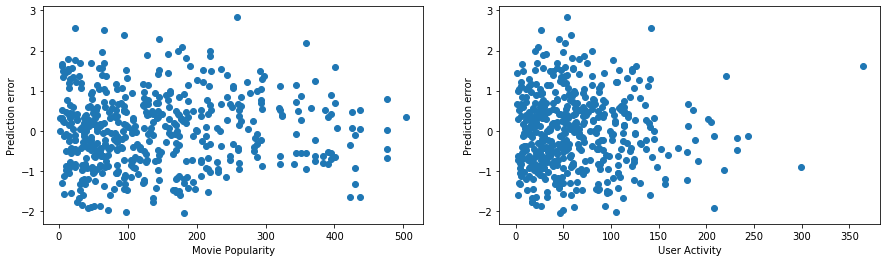

In [120]:
# only plot a subsample for higher readability
subn = 500 
fig, (ax0, ax1) = plt.subplots(ncols=2)
fig.set_figwidth(15)
ax0.scatter(movie_popularity[:subn], err[:subn])
ax0.set_ylabel('Prediction error')
ax0.set_xlabel('Movie Popularity')

ax1.scatter(user_activity[:subn], err[:subn])
ax1.set_ylabel('Prediction error')
ax1.set_xlabel('User Activity');
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right()


Above we plotted the prediction error of (a subset of) test ratings compared to the popularity of movies (left) and acitivity level of users (right). We note that:

- This empirical distribution looks symmetrical so there doesn't seem to be a bias toward lower or higher predictions
- The prediction errors seem to show that movies and users with more data have smaller prediction error (i.e., the data forms a triangle pointing up). This is intuitive, the more data you have about an item the more accurate should be the estimation of its parameters ($\theta_{\text{mid}}$). This could also be reinforced by the fact that we are splitting ratings randomly for train and test (versus splitting by user or item). Hence, popular movies and high-activity users have a great influence in the learning process.

### 2.3 Linear regression with tag features/covariates

We use a linear regression model as above but also model movie tags: 

$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i} \mathbf{+ x_{\text{tags}_i}\boldsymbol\theta_\text{tags}}
$$ 

The last term on the right hand side (bolded) is the only difference wrt to our previous model.  

**Question:** (Before scrolling down) How do you think that this new model will compare to the previous model of Section 2.2? Can you say something definitive about its performance? 

**Hints:** One model is a special case of another.

**Answer:** 
- Model 2.2 is a special case of model 2.3. When $\theta_\text{tags}=0$ both models are equivalent. 
- As such, model 2.3 may outperform model 2.2. It is also possible that the extra covariates lead the model to overfit more easily. 
- Since the model can learn to set $\theta_\text{tags}=0$, model 2.3 should never underperform model 2.2.

In [127]:
# This is very similar to how we constructed our dataset above except that we add the tags columns
X_tags = data_pd_dum.filter(regex=('('+attributes+"|tid_*"+')'))
print(X_tags.shape)

# Split Train/Test. Notice that we use the same seed as above to split the data in the same way.
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags.shape)

(192552, 10048)
(154041, 10048)


In [128]:
# Create linear regression object
regr_tags = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
regr_tags.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("fitting time: %.2f seconds" % fit_time)
print("number of parameters:", regr_tags.coef_.shape[0]+1)

fitting time:  237.934091091156
number of parameters:  1.0013314365818393


In [134]:
print("number of parameters: %d" % regr_tags.coef_.shape[0])

number of parameters: 10048


In [129]:
# Make train predictions
y_train_pred = regr_tags.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_tags.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
# alpha =10
# Train Mean squared error: 0.769
# Test Mean squared error: 0.892
# alpha=50
# Train Mean squared error: 0.863
# Test Mean squared error: 0.936

Train Mean squared error: 0.7878
Test Mean squared error: 0.8571


Remarks: We obtain a test MSE of 0.8571 for model 2.3 compared to a test MSE of 0.865. So the tags do seem to provide slightly better test performance at the expense of a slightly larger model (968 extra parameters to fit) which takes about 30% longer to fit. Take this with a grain of salt because it is hardware dependant. But, this hints at the fact that the fitting algorithm is not linear (i.e., increasing the number of parameters by 10% yields an increase of 30% in running time).

***

### 2.4  Using our movie clusters as covariates in linear regression

Recall that in [Section 1.1](#tag_clustering) we clustered movies using their tag representations. Here we will use the cluster membership as additional covariates. Again the intuition is that this may capture dependancies between tags that would not be available otherwise. 

We start by preparing the data. We use the same operations as above except that we include the `tcluster_*` columns.

In [37]:
X_tags_cluster = data_pd_dum.filter(regex=('('+attributes+"|tid_*|tcluster_*)"))
display(X_tags_cluster.columns)

# Split Train/Test. Again we use the same fixed seed as above for comparison and reproducibility purposes
X_train_tags_cluster, X_test_tags_cluster, y_train_tags_cluster, y_test_tags_cluster = train_test_split(
    X_tags_cluster, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags_cluster.shape)

Index(['age', 'tid_1', 'tid_2', 'tid_3', 'tid_5', 'tid_6', 'tid_7', 'tid_9',
       'tid_10', 'tid_12',
       ...
       'tcluster_90', 'tcluster_91', 'tcluster_92', 'tcluster_93',
       'tcluster_94', 'tcluster_95', 'tcluster_96', 'tcluster_97',
       'tcluster_98', 'tcluster_99'],
      dtype='object', length=10148)
(154041, 10148)


We note that the we now use 10,148 covariates and that the model will also require this number of parameters (+1 for the intercept parameter). 

Now let us train a linear regression model using all available covariates. Models 2.2 and 2.3 are special cases of this model (2.4). The same argument with respect to performanc apply as in our comparison of model 2.3 versus model 2.2.

In [38]:
# Create linear regression object
regr_tags_cluster = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr_tags_cluster.fit(X_train_tags_cluster, y_train_tags_cluster)

print("number of parameters: ", regr_tags_cluster.coef_.shape[0]+1)

number of parameters:  (10148,)


In [39]:
# Make train predictions
y_train_pred = regr_tags_cluster.predict(X_train_tags_cluster)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags_cluster, y_train_pred))

# Make test predictions
y_test_pred = regr_tags_cluster.predict(X_test_tags_cluster)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags_cluster, y_test_pred))
#Train Mean squared error: 0.781
#Test Mean squared error: 0.903

Train Mean squared error: 0.7874
Test Mean squared error: 0.8570


Our results so far are: 
- test MSE of 0.865 for model 2.2
- test MSE of 0.8571 for model 2.3
- test MSE of 0.8570 for mdoel 2.4

We note that while tags help, clusters provide what seems like a very negligeable gain. This seems to show that clusters do not provide much information beyond what is already directly accessible through the movie tags.

### 2.5 Fitting a non-linear model 

So far we have studied the effect of using different features on a linear model. We note that adding features seems to help, as long as the features provide novel and predictive information and are not redundant. 

Here we explore a non-linear model, a one-hidden layer neural network for regression. The task and the data are the same as before, only the model changes.

**Neural network basics:** 
- A neural network is made up of interconnected *neurons*. Each neuron computes a few simple operations. 
- In a *feed-forward network*, neurons are organized into sets called *layers*. 
 - Neurons in each layer get their inputs from the previous layer and send their outputs to the next layer. 
 - The first layer is called the *input layer* it provides data to the next layer. The last layer is the *output layer* it provides a prediction $\hat{y}$. 
 - Layers in between the input layer and the output layer are called *hidden layers*. Each neuron in the hidden layers is a linear regression model followed by a non-linear function (*activation function*): $f(x) = \sum_i x_i \theta_i$. 
  - While the number of neuron in input and output layeyrs are fixed by the data (the number of features and the number of predictions). 
  - The number of neurons of a hidden layer is a hyperparameter. Another hyperparameter is the number of hidden layers. 

Mathematically for a regression task (with a single output), a one-hidden layer neural net is: 
$$ 
f(x) = f_\text{o} ( \sum_{j=0}^{|\text{hidden n.}|} \theta'_{j} f_\text{h}( \sum_{i=0}^{|p|}\theta_{ij} x_i ) ) 
$$ 
where
- $\theta_{ij}$ are the parameters of input $i$ and neuron $j$ in the hidden layer.
- $f_h$ is the activation function of the hidden layer
- $\theta'_{j}$ are the parameters that connect the neuron $j$ in the hidden layer to the output layer.
- $f_o$ is the activation function of the output layer

A intuitive way of visualization a neural net (especially large ones) is to draw neurons as nodes and connections between neurons as arcs:

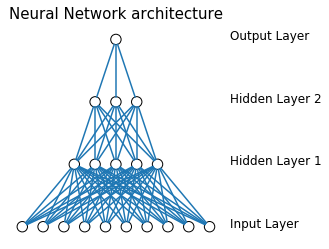

In [176]:
# a 1 hidden layer neural net, where the input has 10 dimensions (p=10) and the output 1
input_dims = 10 # p 
hidden_layers_size = [5, 3] # number of hidden neurons for each hidden layer (adding a dimension adds a layer)
output_dims = 1 # number of outputs

network = DrawNN( [input_dims] + hidden_layers_size + [output_dims] )
network.draw()

In [162]:
# Fit a neural net. on this data. 
regr_nn = neural_network.MLPRegressor(alpha=0.01, # l2-regularization (weight decay)
                                      hidden_layer_sizes=(4,),  # single hidden layer
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True)
start = time.time()
regr_nn.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("fitting time: %.2f seconds" % fit_time)
print("number of parameters:", reduce(lambda x,y: x+y, 
                                       list(map(lambda x: x.size, regr_nn.coefs_+regr_nn.intercepts_)) ))

KeyboardInterrupt: 

Much like previous models we can regularize a neural net to combat overfitting:
- Here we use the same L2-penalty regularizer on all parameters. The strength of this regularizer is given by $\alpha$. 
- In addition, we use a second regularizer called `early-stopping`. Learning the parameters of a neural network is done iteratively using a method called gradient descent (as opposed to linear regression, there is not analytical solution for the parameters given the objective function). Early stopping simply evaluates validation error after each iteration. It stops learning when validation error stops improving. This can happen before the training loss converges. When it does not, then this regularizer has no effect on learning. In `scikit-learn`, the MLPRegressor class with `early_stopping=True` automatically splits a validation set from the training set to be used by this regularizer. The disadvantage of course is that this reduces the amount of data used to fit parameters. 


Note: the training loss of this MLP model is the MSE. However, the reported numbers above "Iteration 19, loss = XX" do not seem to correspond to.

In [159]:
# Make train predictions
y_train_pred = regr_nn.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_nn.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
#Train Mean squared error: 0.781
#Test Mean squared error: 0.903

Train Mean squared error: 0.7821
Test Mean squared error: 0.8641


### FIT NN: end

### Concluding Remarks

`scikit-learn`
-  is a powerful ML library. It is meant as a model toolbox. 
- [Which model to use](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
- It is great to fit existing models

**Questions**

 - Can you think of a ways to use other ratings? 
 - Auto-encoders? 

In [83]:
#list(map(sum, regr_nn.coefs_))
reduce(lambda x,y: x+y, list(map(lambda x: x.size, regr_nn.coefs_)) )
print((1,2) + (1,3))

(1, 2, 1, 3)


## References.

- Scikit-learn 
    - other tutorials 
- other ML tutorials 
- Books
- 



#### Helper functions

In [161]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

#### Scratch

In [33]:
print(type(data_pd_dum.columns.tolist()))

a = list(filter(lambda x: not re.search("tid", x) 
       and not re.search("mid", x) 
       and not re.search("uid", x), 
       data_pd_dum.columns.tolist()))
print(a)

<class 'list'>
['age', 'rating', 'timestamp', 'index', 'relevance', 'gender_F', 'gender_M', 'occupation_0', 'occupation_1', 'occupation_2', 'occupation_3', 'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7', 'occupation_8', 'occupation_9', 'occupation_10', 'occupation_11', 'occupation_12', 'occupation_13', 'occupation_14', 'occupation_15', 'occupation_16', 'occupation_17', 'occupation_18', 'occupation_19', 'occupation_20', 'zip_00', 'zip_01', 'zip_02', 'zip_03', 'zip_04', 'zip_05', 'zip_06', 'zip_07', 'zip_08', 'zip_09', 'zip_10', 'zip_11', 'zip_12', 'zip_13', 'zip_14', 'zip_15', 'zip_16', 'zip_17', 'zip_18', 'zip_19', 'zip_20', 'zip_21', 'zip_22', 'zip_23', 'zip_24', 'zip_25', 'zip_26', 'zip_27', 'zip_28', 'zip_29', 'zip_30', 'zip_31', 'zip_32', 'zip_33', 'zip_34', 'zip_35', 'zip_36', 'zip_37', 'zip_38', 'zip_39', 'zip_40', 'zip_41', 'zip_42', 'zip_43', 'zip_44', 'zip_45', 'zip_46', 'zip_47', 'zip_48', 'zip_49', 'zip_50', 'zip_51', 'zip_52', 'zip_53', 'zip_54', 'zip_55', '

In [140]:
_regr = linear_model.Ridge(alpha=10)

# Train the model using the training sets
start = time.time()
_regr.fit([[0, 1, 2]], [1])
print(_regr.coef_.shape[0]+1)
_regr.intercept_

4


1.0